# Basic dynamical evolution

This notebook demonstrates the following steps, which are the core use case of FreeGSNKE:
- Loading a machine model
- Instantiating a Grad-Shafranov equilibrium and plasma profiles
- Evolving the active coil currents and solving for the evolution of the equilibrium

We start with some core imports.

In [1]:
import numpy as np
import freegs
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output
import time

%load_ext autoreload
%autoreload 2

## Setting up

A few steps need to be performed before a plasma equilibrium can be evolved in time, namely:
- Loading the machine model data and storing in a tokamak object.
- Instantiating an equilibrium and plasma profiles.

### Creating the machine

First, identify the files containing the machine description.

FreeGSNKE requires the user to define the following environment variables:
- `ACTIVE_COILS_PATH`
- `PASSIVE_COILS_PATH`
- `WALL_PATH`
- `LIMITER_PATH`
  
These define the machine geometry and properties. For information on how to create these files, see the `machine_config.ipynb` example notebook.

In [2]:
import os

os.environ["ACTIVE_COILS_PATH"] = "../machine_configs/MAST-U/active_coils_from_UDA.pickle"
os.environ["PASSIVE_COILS_PATH"] = "../machine_configs/MAST-U/passive_coils_from_fiesta_filaments.pickle"
os.environ["WALL_PATH"] = "../machine_configs/MAST-U/wall.pickle"
os.environ["LIMITER_PATH"] = "../machine_configs/MAST-U/limiter.pickle"

Calling the `build_machine.tokamak()` function reads the data from these environment variables and returns a tokamak object.

In [3]:
from freegsnke import build_machine

tokamak = build_machine.tokamak()

### Instantiating an equilibrium

We are now ready to build a plasma equilibrium in the tokamak object. This is done using the `freegs.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is usually recommendable to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters.

At the minimum, a tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial plasma flux function can be provided to the `psi` parameter (commented out in the following code).

In [4]:
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # Radial range
    Zmin=-2.2, Zmax=2.2,  # Vertical range
    nx=65,   # Number of grid points in the radial direction
    ny=129,  # Number of grid points in the vertical direction
    # psi=plasma_psi
)  

Equilibrium data was not provided. Proceeded with default initialization.


A profile object can now be instantiated, which sets the parameterisation and properties of the profile function.

FreeGSNKE accepts the same profile classes available in FreeGS: `ConstrainPaxisIp` or `ConstrainBetapIp`.

The profile object also sets the value of the total plasma current.

The following uses the `ConstrainPaxisIp` function, and an example demonstrating use of the `ConstrainBetapIp` function is in the following text cell.

Equilibrium (`eq`) and limiter (`tokamak.limiter`) objects are passed to the profile to inform calculations relating to the limiter.

The following parameters set the value for the profile properties.
- `paxis`: plasma pressure on axis [Pascals].
- `Ip`: total plasma current [Amps].
- `fvac`: vacuum f = R * Bt.

The `alpha_m` and `alpha_n` coefficients define the 'peakedness' of the plasma current density distribution. See [this paper](https://arxiv.org/abs/1503.03135) for example.

In [5]:
from freegsnke.jtor_update import ConstrainPaxisIp

profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

As promised, here is an example of using `ConstrainBetapIp` instead. The call signature is nearly identical, except the poloidal beta (`betap`) is used instead.

```python
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,
    limiter=tokamak.limiter,
    betap=0.2,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)
```

Now all that's left for the problem initialisation is to set the starting equilibrium. We do this by first assigning current values to the active poloidal field coils. 

The data files used here correspond to a diverted plasma.

The passive structure currents are also set in the following. In this case, they are all set to zero.

In [6]:
import pickle

with open('simple_diverted_currents.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

We now instantiate the static Newton-Krylov solver implemented in FreeGSNKE to solve the Grad-Shafranov equation. This requires the equilibrium as an argument to inform the solver of the domain and grid properties.

In [7]:
from freegsnke import GSstaticsolver

GSStaticSolver = GSstaticsolver.NKGSsolver(eq)

Finally, we call the solver's `solve` method to solve the forward Grad-Shafranov problem corresponding to the tokamak metal currents set above and the requested profile properties.

This again requires the equilibrium object along with the profiles and a relative tolerance that determines the convergence criterion.

In [8]:
GSStaticSolver.solve(
    eq,
    profiles,
    target_relative_tolerance=1e-8,
    verbose=1
)

Picard was used instead of NK in at least 1 cycle.


Now we can plot the equilibrium.

As in FreeGS, the full black line represents the `tokamak.wall`. In addition, the thin black dotted line shows the `tokamak.limiter`, which is the border of the region where the plasma is allowed to be.

The limiter object is passed to the equilibrium object by the profile object during the call to `NK.solve`.

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

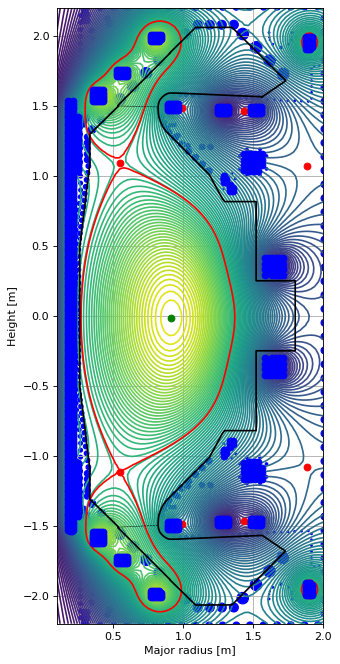

In [9]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True,which='both')
eq.plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)

## Time evolution

We are now ready to solve the forward time-evolutive problem.

To start, we need to initialise the evolutive solver object, `freegsnke.nonlinear_solve.nl_solver`. This uses an equilibrium to inform the solver of the machine and domain properties.

The time-evolutive solver also requires the following:
- The `profiles` defined above
- `full_timestep`: the time step by which time is advanced at every call of the stepper
- `plasma_resistivity`: resistivity of the plasma, which is assumed to be constant during the time evolution.

The solver can be used on different equilibria and/or profiles, but these need to have the same machine, domain and limiter as the one used at the time of the solver instantiation. For different machines, a new time-evolutive solver should be created.

The input equilibrium and profile functions are also used as the expansion point around which the dynamics are linearised.

In [10]:
from freegsnke import nonlinear_solve

stepping = nonlinear_solve.nl_solver(
    eq=eq, profiles=profiles, 
    full_timestep=3e-4, 
    plasma_resistivity=2e-6,
    min_dIy_dI=.1
)

Input max_mode_frequency corresponds to  29  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
I'm building the linearization wrt the profile parameters.
Mode removal is ON: the input min_dIy_dI corresponds to keeping 32 out of the original 41 metal modes.
This equilibrium has a linear growth rate of 1/ 0.03570490095216111 s
The solver's timestep was set at 0.0003  as explicitly requested. Please compare this with the linear growth rate above and, if necessary, reset.


In this example, we will evolve a plasma in absence of any control policy or current drive.

The following calculates active voltages to apply to the poloidal field coils using $V = RI$, in order to maintain the current values that defined the initial equilibrium.

In most FreeGSNKE use cases, these active voltages will be determined by a control policy.

In [12]:
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

The following demonstrates a solely linear evolution of the plasma by setting `linear_only=True`.

To start, the solver is prepared by setting the initial conditions.

In [13]:
stepping.initialize_from_ICs(eq, profiles)

Now we set the total number of time steps we want to simulate and initialise some variables for logging the evolution.

In [14]:
# Functionality for calculation of plasma width, elongation, etc.
from freegsnke import faster_shape

# Number of time steps to simulate
max_count = 50

# Initialising some variables for iteration and logging
counter = 0
t = 0

history_times = [t]
history_currents = [stepping.currents_vec]
history_equilibria = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width = [shapes[0]]
history_o_points = shapes[1]
history_elongation = [shapes[2]]

Finally, we iteratively call the time-evolutive solver with `stepping.nlstepper()` until we reach the pre-set end time.

In [15]:
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')
    
    t_start = time.time()

    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=True
    )

    # Log information on the time-advanced plasma and currents
    t += stepping.dt_step
    history_times.append(t)
    counter += 1

    # Time-advanced currents are recorded in stepping.currents_vec
    history_currents.append(stepping.currents_vec)

    # The time-advanced equilibrium and profile are recorded respectively in
    # stepping.eq1 and stepping.profiles1
    history_equilibria.append(deepcopy(stepping.eq1))
    shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
    history_width.append(shapes[0])
    history_o_points = np.append(history_o_points,shapes[1], axis=0)
    history_elongation.append(shapes[2])

# Collect logs
history_currents = np.array(history_currents)
history_times = np.array(history_times)
history_o_points = np.array(history_o_points)


'Step: 49/49'

'current time t = 1.47e-02'

Now we evolve the same plasma according to the full nonlinear dynamics for the same time interval. This is done by using `linear_only=False` in the call to the stepper.

We need to re-initialise from the initial conditions and reset the counter, but otherwise the method is identical to the one above.

Note that the full nonlinear evolutive solve is a lot more computationally expensive than solving the linear evolutive problem. As such, the following cell may take several minutes to execute, depending on your hardware.

In [16]:
# Reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# Initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width_nl = [shapes[0]]
history_o_points_nl = shapes[1]
history_elongation_nl = [shapes[2]]

# Simulate the forward evolution
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')
    
    t_start = time.time()

    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=False
    )

    # Log information on the time-advanced plasma and currents:
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # Time-advanced currents are recorded in stepping.currents_vec
    history_currents_nl.append(stepping.currents_vec)

    # The time-advanced equilibrium and profile are recorded respectively in
    # stepping.eq1 and stepping.profiles1
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
    history_width_nl.append(shapes[0])
    history_o_points_nl = np.append(history_o_points_nl, shapes[1], axis=0)
    history_elongation_nl.append(shapes[2])

# Collect logs
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)

'Step: 49/49'

'current time t = 1.47e-02'

failed to converge to the requested relative tolerance of 1.2148664098755452e-06 with less than 50 iterations
last relative psi change = 5.561540996019201e-06


The following plots the evolution of the tracked values and compares the linear and nonlinear evolution.

Text(0.5, 1.0, 'Nonlinear')

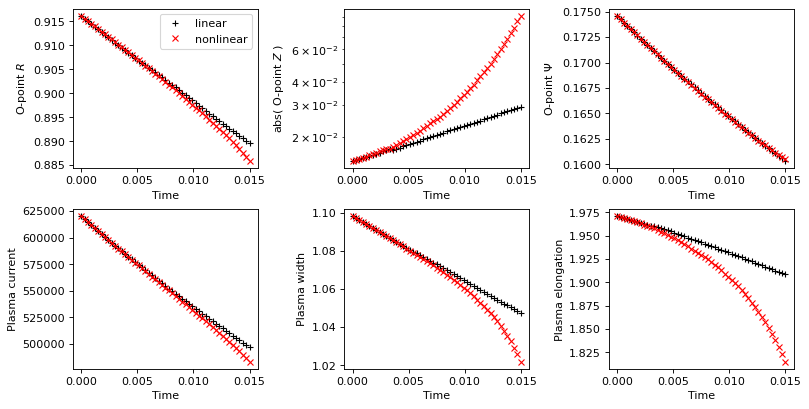

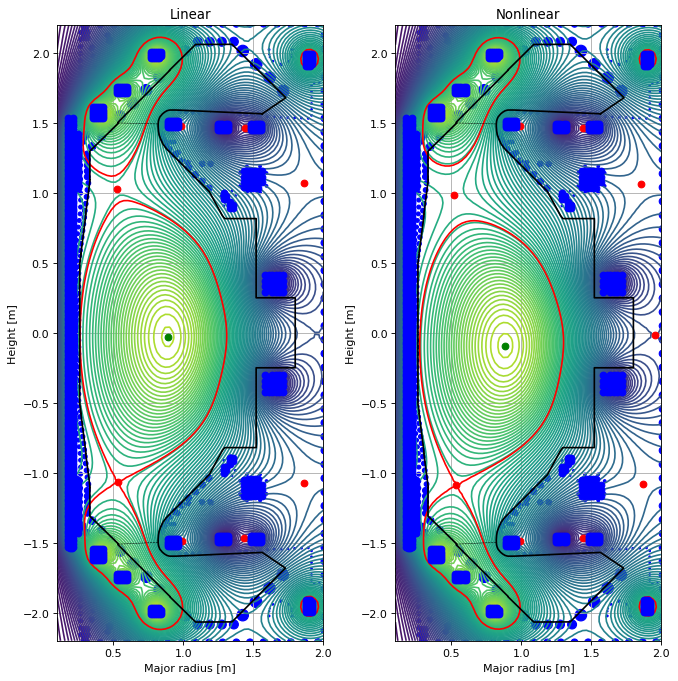

In [20]:
# Plot evolution of tracked values and compare between linear and non-linear evolution
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times, history_o_points[:, 0],'k+', label='linear')
axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')
axs_flat[0].legend()

axs_flat[1].plot(history_times, abs(history_o_points[:, 1]),'k+')
axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs( O-point $Z$ )')

axs_flat[2].plot(history_times, history_o_points[:, 2],'k+')
axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times, history_currents[:,-1]*stepping.plasma_norm_factor,'k+')
axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times, history_width,'k+')
axs_flat[4].plot(history_times_nl, history_width_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times, history_elongation,'k+')
axs_flat[5].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

# Plot equilibria at last simulated time
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(121)
ax.grid(True,which='both')
history_equilibria[-1].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax.set_title('Linear')
ax = fig.add_subplot(122)
ax.grid(True,which='both')
history_equilibria_nl[-1].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax.set_title('Nonlinear')

## Limiter plasma example

Finally, we examine a limiter configuration. There is no fundamental difference from the process described above.

First we re-instantiate the equilibrium object.

In [21]:
eq = freegs.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,
    Zmin=-2.2, Zmax=2.2,
    nx=65, ny=129
)  

We load a set of coil currents that will give us a limiter plasma in our current tokamak.

In [22]:
import pickle
with open('limiter_currents.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]

Now we set the profiles.

In [23]:
profiles = ConstrainPaxisIp(
    eq=eq,
    limiter=tokamak.limiter,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

The final part of the setup is to do a forward solve and visualise the limiter equilibrium.
The red dashed line is the flux surface through the first X-point, however, the actual last closed flux surface in limiter equilibria is displayed as a full black line. 

<AxesSubplot:xlabel='Major radius [m]', ylabel='Height [m]'>

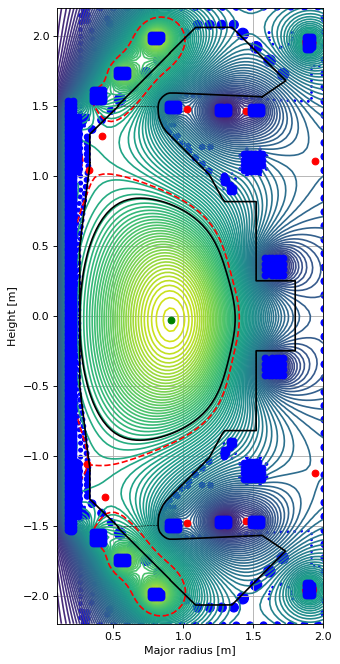

In [24]:
GSStaticSolver.solve(eq, profiles, target_relative_tolerance=1e-8)

fig, ax = plt.subplots(figsize=(5, 10), dpi=80)
ax.grid(True,which='both')
eq.plot(axis=ax, show=False)
eq.tokamak.plot(axis=ax, show=False)

Finally, we can do the nonlienar evolutive solve as before.
First, we re-initialize the solver, which calculates the linearization of the dynamics relevant to this new equilibrium.

In [25]:
stepping = nonlinear_solve.nl_solver(
    eq=eq, profiles=profiles, 
    full_timestep=3e-4, 
    plasma_resistivity=2e-6,    
)

Input max_mode_frequency corresponds to  29  independent vessel normal modes in addition to the  12  active coils.
I'm building the linearization wrt the currents. This may take a minute or two.
I'm building the linearization wrt the profile parameters.
Mode removal is ON: the input min_dIy_dI corresponds to keeping 32 out of the original 41 metal modes.
This equilibrium has a linear growth rate of 1/ 0.5515345252159661 s
The solver's timestep was set at 0.0003  as explicitly requested. Please compare this with the linear growth rate above and, if necessary, reset.


In [26]:
# Recalculate the active voltages using the new currents
U_active = (stepping.vessel_currents_vec*stepping.evol_metal_curr.R)[:stepping.evol_metal_curr.n_active_coils] 

# Number of time steps to simulate
max_count = 40

# Reset the solver object by resetting the initial conditions
stepping.initialize_from_ICs(eq, profiles)

# Initialising some variables for iteration and logging
counter = 0
t = 0

history_times_nl = [t]
history_currents_nl = [stepping.currents_vec]
history_equilibria_nl = [deepcopy(stepping.eq1)]
shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
history_width_nl = [shapes[0]]
history_o_points_nl = shapes[1]
history_elongation_nl = [shapes[2]]

# Simulate the forward evolution
while counter<max_count:
    clear_output(wait=True)
    display(f'Step: {counter}/{max_count-1}')
    display(f'current time t = {t:.2e}')
    
    t_start = time.time()

    stepping.nlstepper(
        active_voltage_vec=U_active, 
        linear_only=False
    )

    # Log information on the time-advanced plasma and currents:
    t += stepping.dt_step
    history_times_nl.append(t)
    counter += 1
    
    # Time-advanced currents are recorded in stepping.currents_vec
    history_currents_nl.append(stepping.currents_vec)

    # The time-advanced equilibrium and profile are recorded respectively in
    # stepping.eq1 and stepping.profiles1
    history_equilibria_nl.append(deepcopy(stepping.eq1))
    shapes = faster_shape.shapes_f(stepping.eq1, stepping.profiles1)
    history_width_nl.append(shapes[0])
    history_o_points_nl = np.append(history_o_points_nl, shapes[1], axis=0)
    history_elongation_nl.append(shapes[2])

# Collect logs
history_currents_nl = np.array(history_currents_nl)
history_times_nl = np.array(history_times_nl)
history_o_points_nl = np.array(history_o_points_nl)

'Step: 39/39'

'current time t = 1.17e-02'

Text(0.5, 1.0, 't=0.011999999999999999')

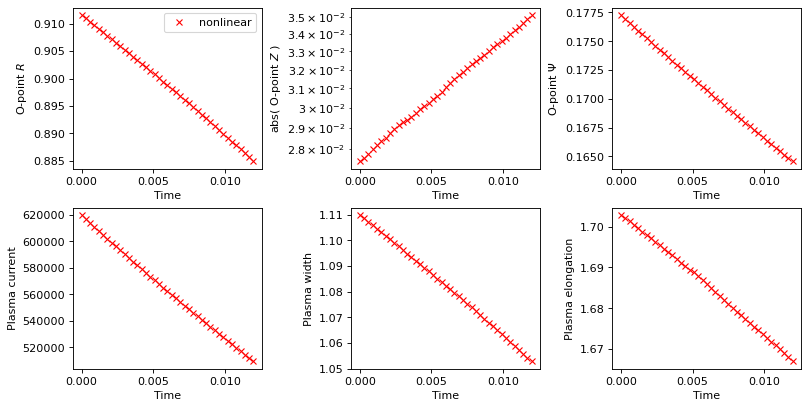

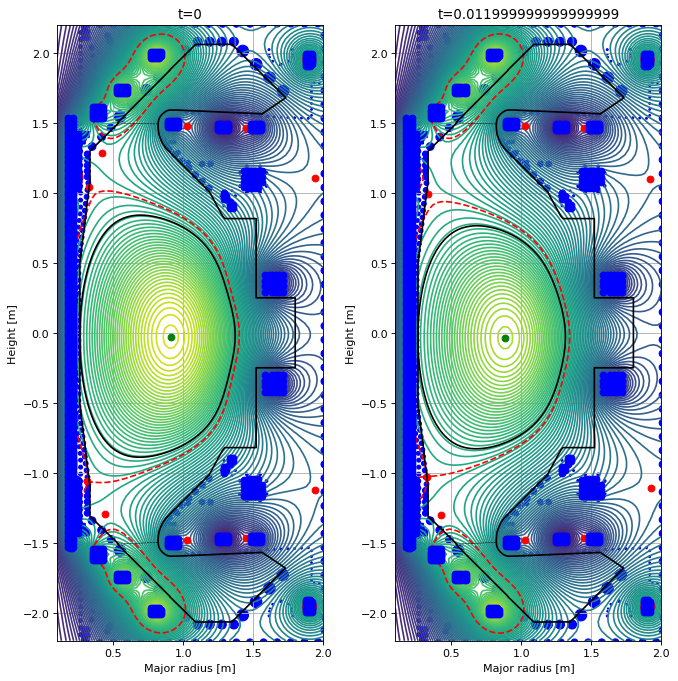

In [27]:
# Plot evolution of tracked values
fig, axs = plt.subplots(2, 3, figsize=(10, 5), dpi=80, constrained_layout=True)
axs_flat = axs.flat

axs_flat[0].plot(history_times_nl, history_o_points_nl[:, 0],'rx', label='nonlinear')
axs_flat[0].set_xlabel('Time')
axs_flat[0].set_ylabel('O-point $R$')
axs_flat[0].legend()

axs_flat[1].plot(history_times_nl, abs(history_o_points_nl[:, 1]),'rx')
axs_flat[1].set_yscale('log')
axs_flat[1].set_xlabel('Time')
axs_flat[1].set_ylabel('abs( O-point $Z$ )')

axs_flat[2].plot(history_times_nl, history_o_points_nl[:, 2],'rx')
axs_flat[2].set_xlabel('Time')
axs_flat[2].set_ylabel('O-point $\Psi$')

axs_flat[3].plot(history_times_nl, history_currents_nl[:,-1]*stepping.plasma_norm_factor,'rx')
axs_flat[3].set_xlabel('Time')
axs_flat[3].set_ylabel('Plasma current')

axs_flat[4].plot(history_times_nl, history_width_nl,'rx')
axs_flat[4].set_xlabel('Time')
axs_flat[4].set_ylabel('Plasma width')

axs_flat[5].plot(history_times_nl, history_elongation_nl,'rx')
axs_flat[5].set_xlabel('Time')
axs_flat[5].set_ylabel('Plasma elongation')

# Plot equilibria at last simulated time
fig = plt.figure(figsize=(10, 10), dpi=80)
ax = fig.add_subplot(121)
ax.grid(True,which='both')
history_equilibria_nl[0].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax.set_title('t=0')
ax = fig.add_subplot(122)
ax.grid(True,which='both')
history_equilibria_nl[-1].plot(axis=ax,show=False)
eq.tokamak.plot(axis=ax,show=False)
ax.set_title('t='+str(t))